In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Evaluate Realism and Diversity of the generated images

This notebook illustrates how to use the generative model package to compute:
- the realism of generated image using the s Frechet Inception Distance (FID) [1] and Maximum Mean Discrepancy (MMD) [2]
- the image diversity using the MS-SSIM [3] and SSIM [4]

Note: We are using the RadImageNet [5] to compute the feature space necessary to compute the FID.

[1] - Heusel et al., "Gans trained by a two time-scale update rule converge to a local nash equilibrium", https://arxiv.org/pdf/1706.08500.pdf

[2] - Gretton et al., "A Kernel Two-Sample Test", https://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf

[3] - Wang et al., "Multiscale structural similarity for image quality assessment", https://ieeexplore.ieee.org/document/1292216

[4] - Wang et al., "Image quality assessment: from error visibility to structural similarity", https://ieeexplore.ieee.org/document/1284395

[5] = Mei et al., "RadImageNet: An Open Radiologic Deep Learning Research Dataset for Effective Transfer Learning, https://pubs.rsna.org/doi/10.1148/ryai.210315

## Setup environment

In [3]:
import torch
import os
import torch
from pathlib import Path

from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.apps import MedNISTDataset
from monai import transforms
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act


from monai.config import print_config
from monai.utils import set_determinism

from generative.metrics import FIDMetric, MMD, MultiScaleSSIMMetric, SSIMMetric
from generative.networks.nets import DiffusionModelUNet, PatchDiscriminator, AutoencoderKL
from generative.networks.schedulers import DDIMScheduler
from generative.inferers import DiffusionInferer

print_config()

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 missing cuda symbols while dynamic loading
 cuFile initialization failed
MONAI version: 1.2.dev2304
Numpy version: 1.23.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.11.2
gdown version: 4.6.0
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



The transformations defined below are necessary in order to transform the input images in the same way that the images were
processed for the RadNet train.

In [4]:
def subtract_mean(x: torch.Tensor) -> torch.Tensor:
    mean = [0.406, 0.456, 0.485]
    x[:, 0, :, :] -= mean[0]
    x[:, 1, :, :] -= mean[1]
    x[:, 2, :, :] -= mean[2]
    return x

def normalize_tensor(x: torch.Tensor, eps: float=1e-10) -> torch.Tensor:
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + eps)

def spatial_average(x: torch.Tensor, keepdim: bool=True) -> torch.Tensor:
    return x.mean([2, 3], keepdim=keepdim)

def get_features(image):

    # If input has just 1 channel, repeat channel to have 3 channels
    if image.shape[1]:
        image = image.repeat(1, 3, 1, 1)

    # Change order from 'RGB' to 'BGR'
    image = image[:, [2, 1, 0], ...]

    # Subtract mean used during training
    image = subtract_mean(image)

    # Get model outputs
    with torch.no_grad():
        feature_image = radnet.forward(image)
        # flattens the image spatially
        feature_image = spatial_average(feature_image, keepdim=False)

    return feature_image

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.
This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = "/tmp/tmpzmzorzlg"
print(root_dir)

/tmp/tmpzmzorzlg


## Set deterministic training for reproducibility

In [6]:
set_determinism(0)

## Define the models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [8]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    latent_channels=3,
    num_channels=[64, 128, 128],
    num_res_blocks=1,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

In [9]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_res_blocks=(1, 1, 1),
    num_channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_head_channels=128
)

scheduler = DDIMScheduler(num_train_timesteps=1000, beta_schedule="linear", beta_start=0.0015, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)
unet = unet.to(device)

## Load pre-trained model

In [10]:
use_pre_trained = True

In [11]:
if use_pre_trained:
    unet = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True)
    unet = unet.to(device)
else:
    cwd = Path.cwd()
    model_path = cwd / Path("tutorials/generative/2d_ldm/best_aeutoencoderkl.pth")
    autoencoderkl.load_state_dict(torch.load(str(model_path)))
    cwd = Path.cwd()
    model_path = cwd / Path("tutorials/generative/2d_ldm/best_unet.pth")
    unet.load_state_dict(torch.load(str(model_path)))

Using cache found in /home/jdafflon/.cache/torch/hub/marksgraham_pretrained_generative_models_v0.2


## Get the real images and syntethic data

In [12]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4)

2023-04-03 21:36:16,283 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-04-03 21:36:16,284 - INFO - File exists: /tmp/tmpzmzorzlg/MedNIST.tar.gz, skipped downloading.
2023-04-03 21:36:16,285 - INFO - Non-empty folder exists in /tmp/tmpzmzorzlg/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:02<00:00, 2483.21it/s]


In [13]:
# Get the real data
real_images = []

pbar = tqdm(enumerate(val_loader), total=len(val_loader))
for step, x in pbar:
    real_img = x["image"].to(device)
    real_images.append(real_img)
    pbar.update()

real_images = torch.cat(real_images, axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 58.77it/s]


Use the model to generate synthetic images. This step will take about 9 mins.

In [21]:
synth_images = []
unet.eval()
for step, x in enumerate(val_loader):
    n_synthetic_images = len(x['image'])
    noise = torch.randn((n_synthetic_images, 1, 64, 64))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=25)

    with torch.no_grad():
        syn_image, intermediates = inferer.sample(input_noise=noise, diffusion_model=unet,
                                                  scheduler=scheduler,save_intermediates=True,
                                                  intermediate_steps=100)
        synth_images.append(syn_image)
synth_images = torch.cat(synth_images, axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.32it/s]


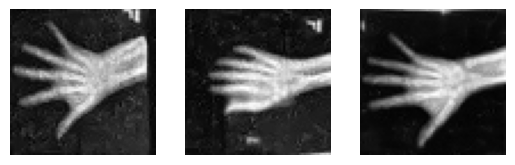

In [22]:
# Plot 3 examples from the synthetic data
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(syn_image[image_n, 0, :, :].cpu(), cmap="gray")
    ax[image_n].axis("off")

## Compute FID

The FID measures the distance between the feature vectors from the real images and those obtained from generated images. In order to compute the FID the images need to be passed into a pre-trained network to get the desired feature vectors. Although the FID is commonly computed using the Inception network, here, we used a pre-trained version of the RadImageNet to calculate the feature space.

In [23]:
radnet = torch.hub.load("Warvito/radimagenet-models", model="radimagenet_resnet50", verbose=True)
radnet.to(device)
radnet.eval()

Using cache found in /home/jdafflon/.cache/torch/hub/Warvito_radimagenet-models_main


ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm

In [24]:
# Get the features for the real data
real_eval_feats = get_features(real_images)

# Get the features for the synthetic data
synth_eval_feats = get_features(synth_images)

In [25]:
synth_eval_feats.shape, real_eval_feats.shape

(torch.Size([1005, 2048]), torch.Size([1005, 2048]))

In [26]:
fid = FIDMetric()
fid_res = fid(synth_eval_feats.to(device), real_eval_feats.to(device))
print(f"FID Score: {fid_res}")

FID Score: tensor(12.9081, device='cuda:0', dtype=torch.float64)


# Compute MMD

In [27]:
y = torch.ones([3, 3, 144, 144, 144])
y_pred =  torch.ones([3, 3, 144, 144, 144])
mmd = MMD()
res = mmd(y, y_pred)

TypeError: split expects at least a 1-dimensional tensor. `data` should be a batch-first tensor or a list of channel-first tensors, got <class 'torch.Tensor'>

In [ ]:
y = torch.ones([3, 144, 144, 144])
y_pred =  torch.ones([3, 144, 144, 144])
mmd = MMD()
res = mmd._compute_metric(y, y_pred)
print(res)

In [ ]:
y = torch.ones([3, 3, 144, 144, 144])
y_pred =  torch.ones([3, 3, 144, 144, 144])
mmd = MMD()
res = mmd(y, y_pred)

In [ ]:
mmd_scores = []
autoencoderkl.eval()

mmd = MMD()

for step, x in list(enumerate(val_loader)):
    image = x["image"].to(device)

    with torch.no_grad():
        image_recon = autoencoderkl.reconstruct(image)

    mmd_scores.append(mmd._compute_metric(image, image_recon))

mmd_scores = torch.stack(mmd_scores)
print(f"MS-SSIM score: {mmd_scores.mean().item():.4f} +- {mmd_scores.std().item():.4f}")


# Compute MultiScaleSSIMMetric and SSIMMetric

Both MS-SSIM and SSIM can be used as metric to evaluate the diversity

Compute the MS-SSIM and SSIM Meteric between the real images and those reconstructed by the AutoencoderKL.

In [29]:
ms_ssim_recon_scores = []
ssim_recon_scores = []
autoencoderkl.eval()

ms_ssim = MultiScaleSSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=4)
ssim = SSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=4)

for step, x in list(enumerate(val_loader)):
    image = x["image"].to(device)

    with torch.no_grad():
        image_recon = autoencoderkl.reconstruct(image)

    ms_ssim_recon_scores.append(ms_ssim(image, image_recon))
    ssim_recon_scores.append(ssim(image, image_recon))

ms_ssim_recon_scores = torch.cat(ms_ssim_recon_scores, dim=0)
ssim_recon_scores = torch.cat(ssim_recon_scores, dim=0)

print(f"MS-SSIM Metric: {ms_ssim_recon_scores.mean():.7f} +- {ms_ssim_recon_scores.std():.7f}")
print(f"SSIM Metric: {ssim_recon_scores.mean():.7f} +- {ssim_recon_scores.std():.7f}")


MS-SSIM Metric: 0.0012073 +- 0.0101628
SSIM Metric: 0.0059797 +- 0.0144561


Compute the SSIM and MS-SSIM between synthetic and real images

In [30]:
ms_ssim_scores = []
ssim_scores = []

ms_ssim_scores.append(ms_ssim(real_images, synth_images))
ssim_scores.append(ssim(real_images, synth_images))

ms_ssim_scores = torch.cat(ms_ssim_scores, dim=0)
ssim_scores = torch.cat(ssim_scores, dim=0)

print(f"MS-SSIM Metric: {ms_ssim_scores.mean():.7f} +- {ms_ssim_scores.std():.7f}")
print(f"SSIM Metric: {ssim_scores.mean():.7f} +- {ssim_scores.std():.7f}")

MS-SSIM Metric: 0.3681146 +- 0.1401891
SSIM Metric: 0.1698659 +- 0.0763002
